In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import configs.config as cfg
import matplotlib.pyplot as plt

# Loading single cell stats and transformed matrix
df = pd.read_csv(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/transformed_matrix.csv", index_col=0).iloc[:,:6]
meta = pd.read_csv(f"{cfg.PROJECT_DIR}/cell_nu_ratio.txt")
meta = meta[(meta.cell_nu_ratio < 8) & (meta.cell_nu_ratio > 1)]
df = df[df.index.isin(meta.image_path)]

In [2]:
protein = "HPA048340_BRG1" # super distinct hit
protein = "CAB080426_HDAC8" # non hit, according to FDR
#protein = "CAB080425_KAT2A" #,'HPA061717_TRIM24', 'HPA062010_MRG15','HPA023083_CBX2'"
protein = ""

shape_d = {}
shape_d['untreated'] = df[df.index.str.contains(protein) & df.index.str.contains('untreated')]
shape_d['vorinostat'] = df[df.index.str.contains(protein) & df.index.str.contains('Vorinostat')]
shape_d['paclitaxel'] = df[df.index.str.contains(protein) & df.index.str.contains('Paclitaxel')]
print([(k, v.shape) for k, v in shape_d.items()])

def stack_pilr(df):
    pilr = []
    for imgpath in df.index:
        names = imgpath.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr_ = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        pilr.append(pilr_.flatten())
    return np.stack(pilr)

pilr_d = {}
pilr_d['untreated'] = stack_pilr(shape_d['untreated'])
pilr_d['vorinostat'] = stack_pilr(shape_d['vorinostat'])
pilr_d['paclitaxel'] = stack_pilr(shape_d['paclitaxel'])

[('untreated', (15249, 6)), ('vorinostat', (4545, 6)), ('paclitaxel', (10231, 6))]


(array([7.76124408e-07, 2.73685976e-06, 2.49585270e-05, 4.58594212e-05,
        3.87926042e-05, 1.82457317e-05, 6.05921687e-06, 1.52501638e-06,
        2.85940571e-07, 6.80810885e-08]),
 array([-32733.95613065, -25555.59291579, -18377.22970093, -11198.86648606,
         -4020.5032712 ,   3157.85994366,  10336.22315852,  17514.58637339,
         24692.94958825,  31871.31280311,  39049.67601797]),
 <BarContainer object of 10 artists>)

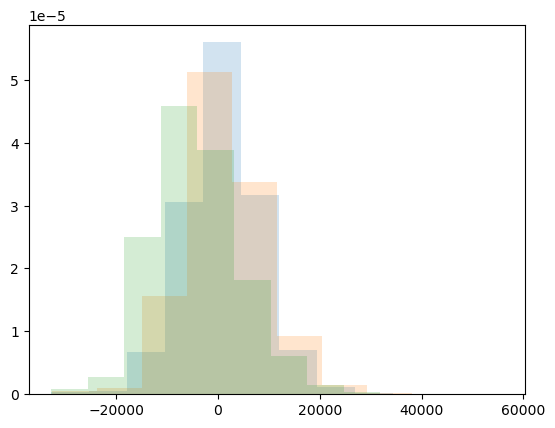

In [10]:
import matplotlib.pyplot as plt
plt.hist(shape_d['untreated'].PC1, density = True, alpha = 0.2)
plt.hist(shape_d['vorinostat'].PC1, density = True, alpha = 0.2)
plt.hist(shape_d['paclitaxel'].PC1, density = True, alpha = 0.2)

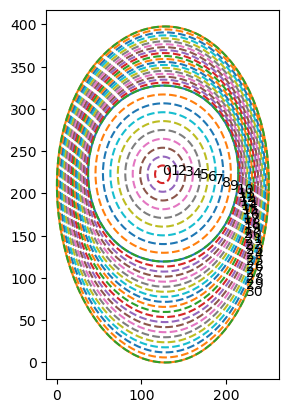

In [11]:
avg_cell = np.load(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/Avg_cell.npz")
nu_centroid = [0, 0]
ix_n = avg_cell["ix_n"]
iy_n = avg_cell["iy_n"]
ix_c = avg_cell["ix_c"]
iy_c = avg_cell["iy_c"]
# Move average shape from zero-centered coords to min=[0,0]
min_x = np.min(ix_c)
min_y = np.min(iy_c)
nu_centroid[0] -= min_x
nu_centroid[1] -= min_y
ix_n -= min_x
iy_n -= min_y
ix_c -= min_x
iy_c -= min_y

from warps import parameterize
x_, y_ = parameterize.get_coordinates(
    np.concatenate([ix_n, iy_n]), 
    np.concatenate([ix_c, iy_c]), 
    nu_centroid, n_isos=cfg.N_ISOS, plot=True
)

x = np.array(x_).round().astype("uint16")
y = np.array(y_).round().astype("uint16")

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


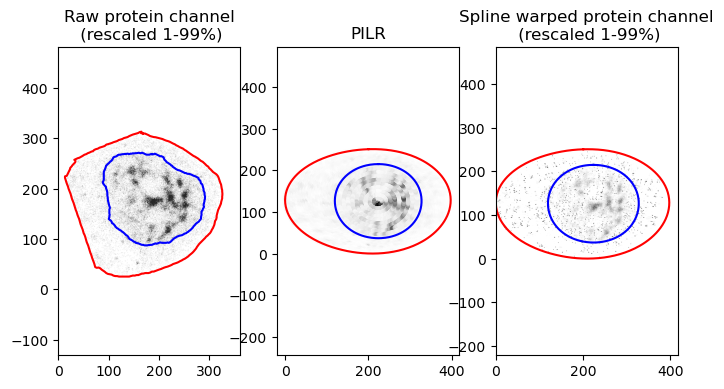

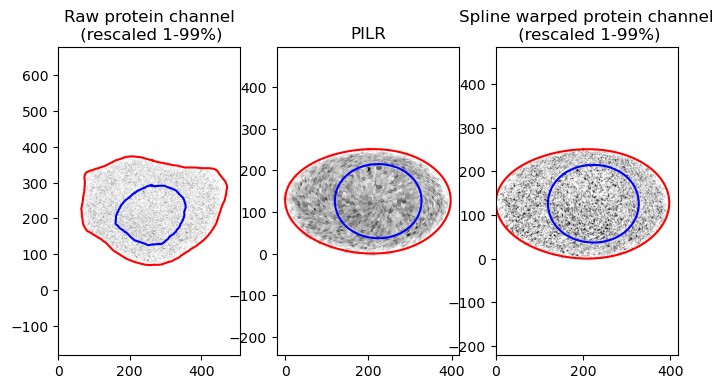

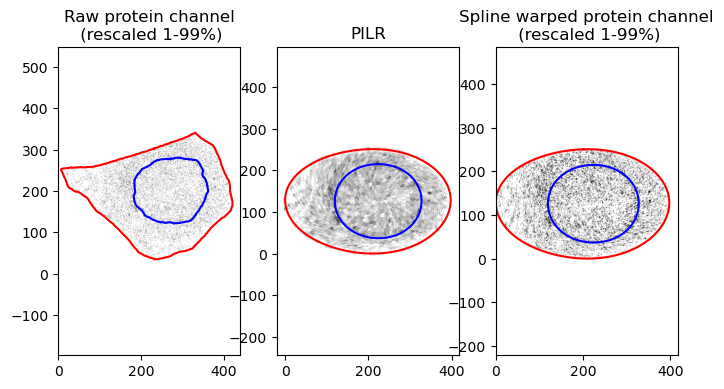

In [12]:
import matplotlib.pyplot as plt
#from shapely.geometry import Polygon
from skimage import img_as_float
from skimage import exposure
from utils.helpers import get_line
from scipy.ndimage import center_of_mass, rotate
from analysis.stats_helpers import draw_contour_on_image
from coefficients import coefs

fft_shift_path = f"{cfg.PROJECT_DIR}/fftcoefs/{cfg.ALIGNMENT}/shift_error_meta_fft128.txt"
shape_coef_path = f"{cfg.PROJECT_DIR}/fftcoefs/{cfg.ALIGNMENT}/fftcoefs_128.txt"

def sharpen(image):
    img_as_float(image)
    pl, ph = np.percentile(image, (1, 99))
    img_rescale = exposure.rescale_intensity(image, in_range=(pl, ph))
    return img_rescale

for imgpath in shape_d['vorinostat'].sample(3).index:
    names = imgpath.replace('.npy','').split('/')
    img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
    img = plt.imread(f"{cfg.PROJECT_DIR}/cell_masks/{names[-3]}/{names[-2]}/{names[-1]}_protein.png")
    img = sharpen(img)
    shape = np.load(f"{cfg.PROJECT_DIR}/cell_masks/{names[-3]}/{names[-2]}/{names[-1]}.npy")
    fft_coefs = get_line(fft_shift_path, search_text=imgpath, mode="first")
    vals = fft_coefs.strip().split(";") 
    theta = float(vals[1])
    shifts = eval(vals[2])
    # Rotate all channels 

    nu_ = rotate(shape[0,:,:], theta)   
    cell_ = rotate(shape[1,:,:], theta)    
    img = rotate(img, theta)
    center_cell = center_of_mass(cell_)
    center_nuclei = center_of_mass(nu_)
    if (
        center_cell[1] > center_nuclei[1]
    ):  # Move 2 quadrant counter-clockwise
        cell_ = rotate(cell_, 180)
        nu_ = rotate(nu_, 180)
        img = rotate(img, 180)
    cell_ = rotate(cell_, 180)
    nu_ = rotate(nu_, 180)
    img = rotate(img, 180)
    #img = draw_contour_on_image(cell_, img, color = (0, 0, 255))
    #img = draw_contour_on_image(nu_, img, color = (255, 0, 0))
    fft_coefs = get_line(shape_coef_path, search_text=imgpath, mode="first")
    f_coef_c = fft_coefs.split(",")[1 : cfg.N_COEFS * 2 + 1]
    f_coef_c = [complex(s.replace("i", "j")) for s in f_coef_c]
    f_coef_n = fft_coefs.split(",")[cfg.N_COEFS * 2 + 1 :]
    f_coef_n = [complex(s.replace("i", "j")) for s in f_coef_n]
    ix_n_ori, iy_n_ori = coefs.inverse_fft(f_coef_n[0:cfg.N_COEFS], f_coef_n[cfg.N_COEFS:])
    ix_c_ori, iy_c_ori = coefs.inverse_fft(f_coef_c[0:cfg.N_COEFS], f_coef_c[cfg.N_COEFS:])
    ix_n_ori += shifts[0]
    ix_c_ori += shifts[0]  
    iy_n_ori += shifts[1]
    iy_c_ori += shifts[1]
    
    img = np.clip(img, 0, img.max())
    pilr = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}_protein.npy")
    mask = 1*(pilr > 165)
    pilr = pilr*mask
    warped = plt.imread(f"{cfg.PROJECT_DIR}/warps/{img_id}_protein.png")
    fig, ax = plt.subplots(1,3, figsize=(8,4))
    ax[0].imshow(img, cmap = "binary", origin='lower')
    ax[0].plot(iy_n_ori, ix_n_ori, 'b')
    ax[0].plot(iy_c_ori, ix_c_ori, 'r')
    #ax[0].set_title(f'Maxval {img.max():2.2f}')
    ax[0].axis('equal')
    ax[0].set_title(f'Raw protein channel\n (rescaled 1-99%)')
    #ax[1].imshow(pilr, cmap = "binary")
    ax[1].scatter(y.flatten(), x.flatten(), c=pilr.flatten(), cmap='binary', s=5)
    ax[1].plot(iy_n, ix_n, 'b')
    ax[1].plot(iy_c, ix_c, 'r')
    ax[1].axis('equal')
    ax[1].set_title(f'PILR')
    ax[2].imshow(sharpen(warped), cmap = "binary", origin='lower')
    ax[2].plot(iy_n, ix_n, 'b')
    ax[2].plot(iy_c, ix_c, 'r')
    ax[2].axis('equal')
    ax[2].set_title(f'Spline warped protein channel\n (rescaled 1-99%)')

Explained variance ratio: 90.47%
LDA Model Accuracy, on training: 65.99%


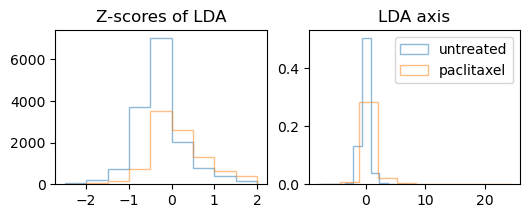

In [13]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import cdist

def find_nearest_neighbors(distances):
    nearest_neighbors = np.argmin(distances, axis=0)
    unique_flagged_cells = np.unique(nearest_neighbors)  # Get unique flagged cells
    return unique_flagged_cells

def create_shape_matched_dataset(baseline_data, second_data, flagged_cells):
    labels = [0] * flagged_cells.shape[0] + [1] * second_data.shape[0]
    shape_matched_data = np.concatenate([baseline_data[flagged_cells,:], second_data])
    return shape_matched_data, labels

def perform_pca(data, n_components=32):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    return pca_data, pca

def perform_lda(shape_matched_data, labels):
    lda = LinearDiscriminantAnalysis()
    lda_data = lda.fit_transform(shape_matched_data, labels)
    return lda_data, lda

def z_score(data, mean=None):
    if not mean:
        mean = np.mean(data)
    return (data - mean) / np.std(data)

def shape_matched_and_lda(shapespace_untreated, shapespace_treated, feature_untreated, feature_treated, shapematch=True, reduce=True):
    if shapematch:
        distances = cdist(shapespace_untreated, shapespace_treated)
        flagged_cells = find_nearest_neighbors(distances)
        combined_data, labels = create_shape_matched_dataset(feature_untreated, feature_treated, flagged_cells)
        indexes = list(shapespace_untreated.index[flagged_cells]) + list(shapespace_treated.index)
    else:
        labels = [0] * feature_untreated.shape[0] + [1] * feature_treated.shape[0]
        combined_data = np.concatenate([feature_untreated, feature_treated])
        indexes = list(shapespace_untreated.index) + list(shapespace_treated.index)
    if reduce:
        n_components = 124 if combined_data.shape[0] >= 124 else 32
        pca_data, pca_model = perform_pca(combined_data, n_components=n_components)
        print(f"Explained variance ratio: {pca_model.explained_variance_ratio_.sum() * 100:.2f}%")
        inputs = pca_data
    else:
        inputs = combined_data
        pca_model = None
        
    lda_data, lda_model = perform_lda(inputs, labels)
    from sklearn.metrics import accuracy_score
    y_pred = lda_model.predict(inputs)
    accuracy = accuracy_score(labels, y_pred)
    print(f"LDA Model Accuracy, on training: {accuracy * 100:.2f}%")
    combined_data = pd.DataFrame(combined_data)
    combined_data['labels'] = labels
    combined_data['lda_data'] = lda_data
    combined_data['img_path'] = indexes
    combined_data['zscores'] = z_score(lda_data)
    return lda_model, pca_model, combined_data, accuracy

cond1, cond2 = 'untreated', 'paclitaxel'
lda_model, pca_model, combined_data, accuracy = shape_matched_and_lda(shape_d[cond1], shape_d[cond2], pilr_d[cond1], pilr_d[cond2], shapematch=False, reduce=True)
if accuracy > 0.995:
    n_bin = 2
else:
    n_bin = 5
binedges = np.arange(-2.5, 2.5, 0.5)
fig, ax = plt.subplots(1, 2, figsize=(6,2))
ax[0].hist(combined_data.zscores[combined_data.labels == 0], bins=binedges, alpha = 0.5, label=cond1, histtype='step', density=False)
ax[0].hist(combined_data.zscores[combined_data.labels == 1], bins=binedges, alpha = 0.5, label=cond2, histtype='step', density=False)
ax[0].set_title(f'Z-scores of LDA')
ax[1].hist(combined_data.lda_data[combined_data.labels == 0], alpha = 0.5, label=cond1, histtype='step', density=True)
ax[1].hist(combined_data.lda_data[combined_data.labels == 1], alpha = 0.5, label=cond2, histtype='step', density=True)
ax[1].set_title(f'LDA axis')

#hist, binedges = np.histogram(combined_data.zscores, bins=n_bin, density=True)
#binedges = [-2.5,-1.5,-0.5,0.5,1.5,2.5]
#for i in range(len(hist)):
#    plt.axvline(binedges[i], color='black', linestyle='--')
plt.legend()

336
5322
15204
3068
892


Text(0.5, 0.98, ': PILR from untreated to paclitaxel in LDA bins')

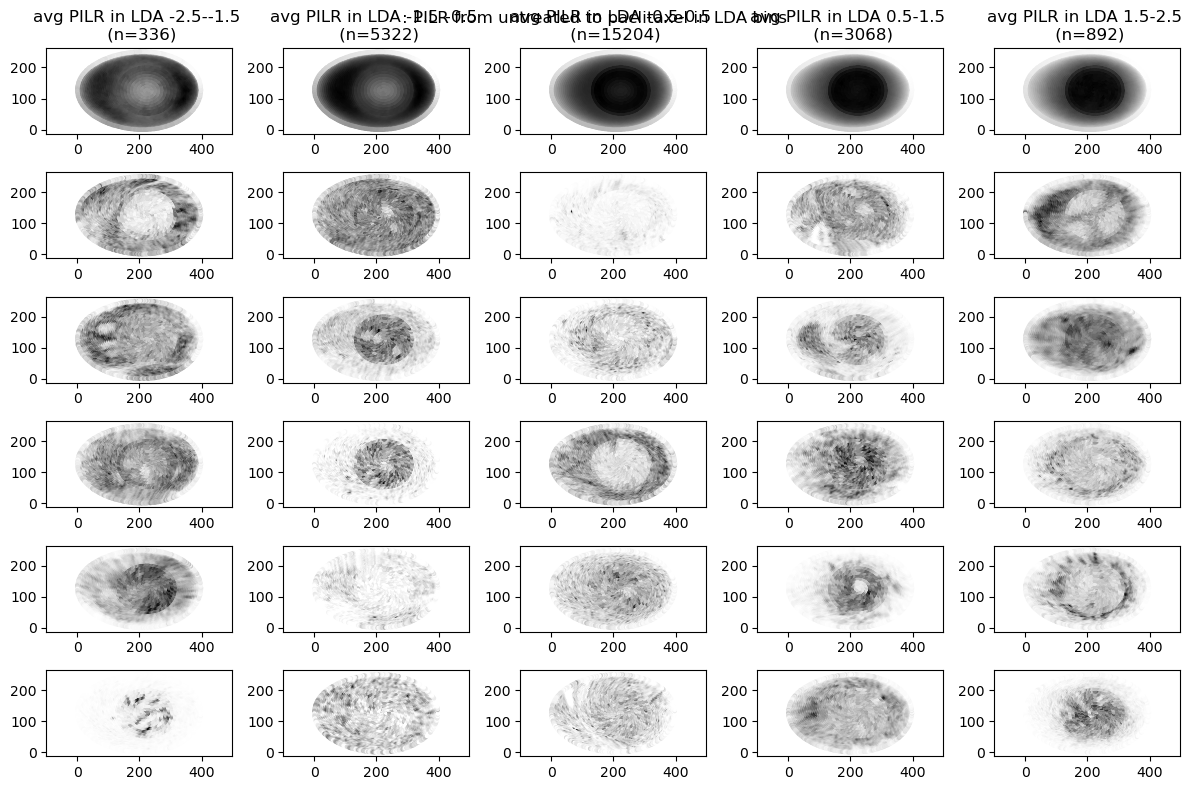

In [14]:
binedges = np.arange(-2.5, 3, 1)
fig, ax = plt.subplots(6, len(binedges) -1, figsize=(12,8))
for i in range(len(binedges) -1):
    mask = (combined_data.zscores >= binedges[i]) & (combined_data.zscores < binedges[i+1])
    pilr = combined_data.iloc[:, :-4].to_numpy()[mask].mean(axis=0)
    ax[0,i].scatter(y.flatten(), x.flatten(), c=pilr.flatten(), cmap='binary', s=5)
    ax[0,i].axis('equal')
    ax[0,i].set_title(f'avg PILR in LDA {binedges[i]}-{binedges[i+1]} \n (n={mask.sum()})')
    print(len(combined_data.img_path[mask]))
    try:
        for j, imgpath in enumerate(combined_data.img_path[mask].sample(5)):
            names = imgpath.replace('.npy','').split('/')
            img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
            pilr = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}_protein.npy")
            ax[j+1, i].scatter(y.flatten(), x.flatten(), c=pilr.flatten(), cmap='binary', s=5)
            ax[j+1, i].axis('equal')
    except:
        pass
plt.tight_layout()
plt.suptitle(f'{protein}: PILR from {cond1} to {cond2} in LDA bins')

In [15]:
combined_data.img_path[mask]

43       /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
106      /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
144      /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
1147     /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
1261     /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
                               ...                        
25467    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
25468    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
25471    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
25473    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
25478    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...
Name: img_path, Length: 892, dtype: object

In [16]:
combined_data.img_path[mask]
for imgpath in shape_d['vorinostat'].sample(5).index:
    names = imgpath.replace('.npy','').split('/')
    img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
    img = plt.imread(f"{cfg.PROJECT_DIR}/cell_masks/{names[-3]}/{names[-2]}/{names[-1]}_protein.png")
    shape = np.load(f"{cfg.PROJECT_DIR}/cell_masks/{names[-3]}/{names[-2]}/{names[-1]}.npy")

In [17]:
import os
# LDA accuracy for each proteins
if os.path.exists(f"{cfg.PROJECT_DIR}/lda_on_pilr_accuracy_per_protein.csv"):
    res_df = pd.read_csv(f"{cfg.PROJECT_DIR}/lda_on_pilr_accuracy_per_protein.csv")
else:
    res = [['Protein', 'Condition1', 'Condition2', 'Accuracy']]
    proteins = list(set([imgpath.split('/')[-3] for imgpath in df.index]))
    for protein in proteins:
        # shape arrays
        df_untreated = df[df.index.str.contains(protein) & df.index.str.contains('untreated')]
        df_vorinostat = df[df.index.str.contains(protein) & df.index.str.contains('Vorinostat')]
        df_paclitaxel = df[df.index.str.contains(protein) & df.index.str.contains('Paclitaxel')]
        
        # PILR arrays
        pilr_untreated = stack_pilr(df_untreated)
        pilr_vorinostat = stack_pilr(df_vorinostat)
        pilr_paclitaxel = stack_pilr(df_paclitaxel)

        lda_data, lda_model, pca_model, labels, combined_data, accuracy = shape_matched_and_lda(df_untreated, df_vorinostat, pilr_untreated, pilr_vorinostat, shapematch=False, reduce=True)
        res.append([protein, 'untreated', 'vorinostat', accuracy])
        
        lda_data, lda_model, pca_model, labels, combined_data, accuracy = shape_matched_and_lda(df_untreated, df_paclitaxel, pilr_untreated, pilr_paclitaxel, shapematch=False, reduce=True)
        res.append([protein, 'untreated', 'paclitaxel', accuracy])   
        
        lda_data, lda_model, pca_model, labels, combined_data, accuracy = shape_matched_and_lda(df_vorinostat, df_paclitaxel, pilr_vorinostat, pilr_paclitaxel, shapematch=False, reduce=True)
        res.append([protein, 'vorinostat', 'paclitaxel', accuracy])
    res_df = pd.DataFrame(res[1:], columns = res[0])
    res_df.groupby(['Condition1', 'Condition2']).Accuracy.mean()
    res_df.to_csv(f"{cfg.PROJECT_DIR}/lda_on_pilr_accuracy_per_protein.csv", index=False)   

res_df.groupby(['Condition1', 'Condition2']).Accuracy.mean()

Condition1  Condition2
untreated   paclitaxel    0.926694
            vorinostat    0.977097
vorinostat  paclitaxel    0.952975
Name: Accuracy, dtype: float64

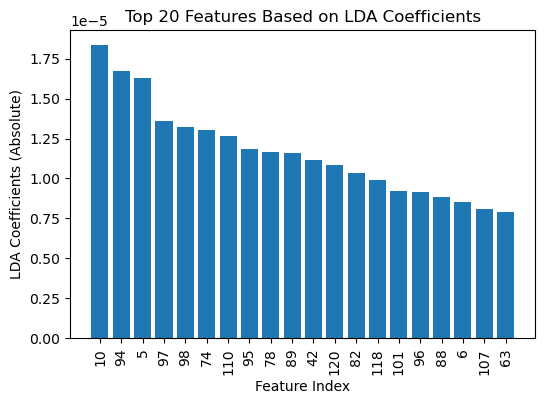

In [18]:
# Extract LDA coefficients
lda_coefficients = np.abs(lda_model.coef_[0])

# Sort by importance
sorted_idx = np.argsort(lda_coefficients)[::-1]

# Plot the top 20 features based on LDA coefficients
plt.figure(figsize=(6, 4))
plt.bar(range(20), lda_coefficients[sorted_idx[:20]])
plt.xticks(range(20), sorted_idx[:20], rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('LDA Coefficients (Absolute)')
plt.title('Top 20 Features Based on LDA Coefficients')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def permutation_importance(model, X, y, n_repeats=10):
    baseline_acc = accuracy_score(y, model.predict(X))
    importances = np.zeros(X.shape[1])
    
    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:, col] = shuffle(X_permuted[:, col])
            permuted_acc = accuracy_score(y, model.predict(X_permuted))
            scores.append(baseline_acc - permuted_acc)
        importances[col] = np.mean(scores)
    
    return importances

# Calculate permutation importance
importances = permutation_importance(lda_model, pca_model.transform(combined_data), labels)

# Visualize top 20 features
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(6, 4))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), sorted_idx[:20], rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Permutation Importance')
plt.title('Top 20 Features by Permutation Importance')
plt.show()

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

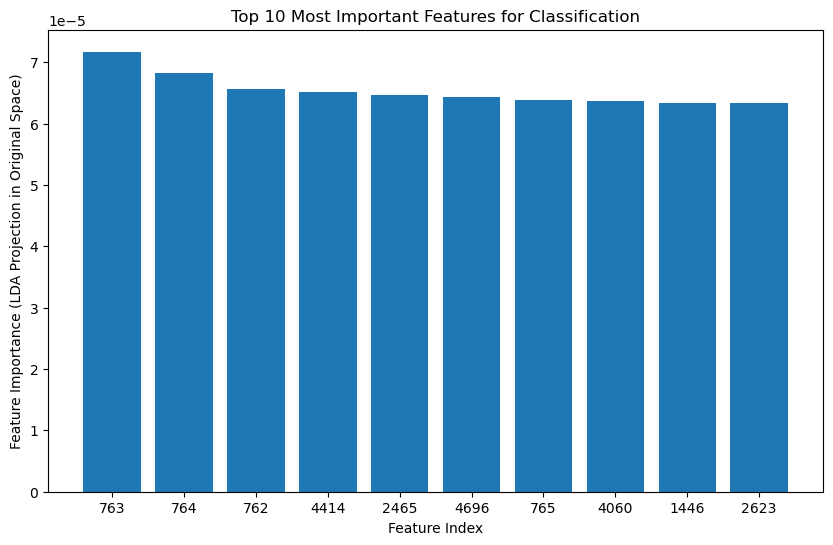

In [ ]:
lda_in_original_space = np.dot(lda_model.coef_, pca_model.components_)

# Step 4: Rank the features based on their absolute contributions
feature_importance = np.abs(lda_in_original_space).ravel()

# Sort the features by importance and get their indices
top_features_idx = np.argsort(feature_importance)[-10:][::-1]  # Top 10 most important features

# Step 5: Plot the importance of the top features
plt.figure(figsize=(10, 6))
plt.bar(np.arange(10), feature_importance[top_features_idx], tick_label=top_features_idx)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance (LDA Projection in Original Space)')
plt.title('Top 10 Most Important Features for Classification')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the lda_in_original_space (projection of LDA back into original space)
# Step 1: Get the index of the most important feature
most_important_feature_idx = np.argmax(np.abs(lda_in_original_space))

# Step 2: Extract this feature from untreated and treated data
untreated_important_feature = pilr_untreated[:, most_important_feature_idx]
treated_important_feature = pilr_vorinostat[:, most_important_feature_idx]

print(untreated_important_feature.shape)
# Step 3: Decode the most important feature for untreated and treated conditions into images
untreated_image = reverse_display(untreated_important_feature)
treated_image = reverse_display(treated_important_feature)

# Step 4: Plot the untreated and treated images, and the difference
plt.figure(figsize=(12, 4))

# Untreated condition
plt.subplot(1, 3, 1)
plt.imshow(untreated_image, cmap='gray')
plt.title('Untreated Condition')

# Treated condition
plt.subplot(1, 3, 2)
plt.imshow(treated_image, cmap='gray')
plt.title('Treated Condition')

# Difference between treated and untreated (absolute difference)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(treated_image - untreated_image), cmap='gray')
plt.title('Difference (Treated - Untreated)')

plt.show()

(93,)


NameError: name 'reverse_display' is not defined

In [ ]:
import pandas as pd
locations = pd.read_csv(f"{cfg.PROJECT_DIR}/location_comparison.csv")
locations['Protein'] = ['_'.join(f.split('_')[:2]) for f in locations.id]
locations['treatment'] = [f.split('_')[-3] for f in locations.id]
locations[locations.annotations == 'Cytosol'].Protein.value_counts()

Protein
HPA008445_YWHAE     24
HPA048723_HDAC4     21
HPA044342_PRKAB2    17
HPA011212_YWHAB     15
CAB080430_DNMT1     13
HPA021876_MBTD1     13
HPA061603_YWHAZ     13
HPA035977_KMT2D     12
HPA055839_P-CAF     11
HPA053723_KDM5B     10
HPA035409_PRKAA1    10
HPA027956_CBL        8
HPA062889_EYA3       8
HPA049408_UHRF1      8
HPA072136_PRMT1      7
HPA060171_BRD7       7
HPA004247_PRKAB1     7
HPA048321_PRKCB      7
HPA048431_KMT3B      6
HPA003714_HDAC6      6
CAB079921_PPP1CC     5
HPA058068_BAZ1B      5
HPA004246_PRKAG2     5
HPA051773_BRE1A      4
CAB080429_BRPF1      3
HPA002636_AURKA      3
HPA050845_TET3       2
HPA023083_CBX2       2
HPA021152_PDP1       2
HPA028926_HDAC9      2
HPA048340_BRG1       2
HPA077805_PRKAG1     2
HPA065425_PPP1CB     2
CAB079904_USP7       1
HPA023567_MSL1       1
HPA042866_KMT2E      1
HPA043837_PPP4C      1
HPA019662_HDAC10     1
HPA065052_KAT6A      1
Name: count, dtype: int64

In [ ]:
tmp = locations.groupby(['Protein','treatment']).aggregate({'annotations':set}).reset_index()
tmp[tmp.Protein.isin(['CAB080425_KAT2A','HPA061717_TRIM24', 'HPA062010_MRG15','HPA023083_CBX2'])]

,Protein,treatment,annotations
6,CAB080425_KAT2A,Paclitaxel,{Nucleoplasm}
7,CAB080425_KAT2A,Vorinostat,{Nucleoplasm}
8,CAB080425_KAT2A,untreated,{Nucleoplasm}
98,HPA023083_CBX2,Paclitaxel,{Nucleoplasm}
99,HPA023083_CBX2,Vorinostat,"{Cytosol, Nucleoplasm}"
100,HPA023083_CBX2,untreated,"{Cytosol,Nucleoplasm, Nucleoplasm}"
229,HPA061717_TRIM24,Paclitaxel,{Nucleoplasm}
230,HPA061717_TRIM24,Vorinostat,{Nucleoplasm}
231,HPA061717_TRIM24,untreated,"{Micronucleus,Nucleoplasm, Nucleoplasm}"
232,HPA062010_MRG15,Paclitaxel,"{Micronucleus,Nucleoplasm, Nucleoplasm}"
